In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockticker10tweetsdataset-23221/stockticker10-tweets(dataset 23-2-21).csv
/kaggle/input/stockticker10tweets5321/stockticker10-tweets(5-3-21).csv
/kaggle/input/stockticker10tweets/stockticker10-tweets.csv
/kaggle/input/main-reddit-manual-gme1616872068/MAIN_Reddit_Manual - gme1616872068.csv
/kaggle/input/stockticker10tweets5321-label/stockticker10-tweets(5-3-21) label.csv


In [2]:
# Plotting/Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import csv

from textblob import TextBlob
import re

import nltk
# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('vader_lexicon')

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# df = pd.read_csv("../input/stockticker10tweets5321-label/stockticker10-tweets(5-3-21) label.csv")
df = pd.read_csv("../input/stockticker10tweets/stockticker10-tweets.csv")
df.head()

,Query,Datetime(UTC),Tweet ID,Text,Username,RT,RT Count,Fav Count,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact)
0,$GME,5/3/2021 6:00,1.367720e+18,Think we're scared of the market makers?\n\n$A...,indigodisruptor,Y,9,0,NaN,NaN
1,$GME,5/3/2021 6:00,1.367720e+18,What these suits don’t know is $amc $gme wasn’...,Ladude2014,Y,5,0,NaN,NaN
2,$GME,5/3/2021 6:00,1.367720e+18,Holy shit LMFAO. \n$AMC $GME \n\nTRUST THE APE...,handsomephil5,Y,48,0,NaN,NaN
3,$GME,5/3/2021 6:00,1.367720e+18,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,N,0,0,0.0,1.0
4,$GME,5/3/2021 6:00,1.367720e+18,Amc Buy and hold Short Intrest borrow fee up t...,itsfibonacci96,Y,10,0,NaN,NaN


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Query                          10000 non-null  object 
 1   Datetime(UTC)                  10000 non-null  object 
 2   Tweet ID                       10000 non-null  float64
 3   Text                           10000 non-null  object 
 4   Username                       10000 non-null  object 
 5   RT                             10000 non-null  object 
 6   RT Count                       10000 non-null  int64  
 7   Fav Count                      10000 non-null  int64  
 8   Sentiment (2pos/1neu/0neg)     1008 non-null   float64
 9   Subjectivity (1opinion/0fact)  1008 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [5]:
df = df.drop(['Datetime(UTC)','Tweet ID','RT', 'RT Count', 'Fav Count'], axis=1)
df.dropna(subset=['Sentiment (2pos/1neu/0neg)'], inplace=True)
df.head()

,Query,Text,Username,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact)
3,$GME,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,0.0,1.0
6,$GME,Astounding that the $GME July $800 Call was up...,ColtStock,2.0,1.0
8,$GME,phantom stock at DTC created by illegal naked ...,AFakeBenONeill,0.0,1.0
20,$GME,GameStop Rally Thursday Likely Fueled By Ryan ...,QuantData,1.0,1.0
21,$GME,TD Ameritrade restricting Short Selling of $GM...,ajit_p_singh,0.0,1.0


In [6]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text)
    text = text.lower()
    text = text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    rem_tweet = re.sub('@[^\s]+','',rem_num)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_tweet)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

df['cleanText'] = df['Text'].apply(preprocess)

In [7]:
df_cleanText = df['cleanText']
df_cleanText

3       guh fidelity closed shares gme risk liquidatio...
6             astounding gme july call today heavy volume
8       phantom stock dtc created illegal naked shorts...
20      gamestop rally thursday likely fueled ryan coh...
21      ameritrade restricting short selling gme rkt u...
                              ...                        
9968    google follows apple path greater online priva...
9970    nasdaq index closed time highs today time buyi...
9984    wierd little bit unpopular miss crazy dad gme ...
9990        dogecoin doge performing better aapl let sink
9995    apple clarifies siri setting default music ser...
Name: cleanText, Length: 1008, dtype: object

In [8]:
df.head()

,Query,Text,Username,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact),cleanText
3,$GME,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,0.0,1.0,guh fidelity closed shares gme risk liquidatio...
6,$GME,Astounding that the $GME July $800 Call was up...,ColtStock,2.0,1.0,astounding gme july call today heavy volume
8,$GME,phantom stock at DTC created by illegal naked ...,AFakeBenONeill,0.0,1.0,phantom stock dtc created illegal naked shorts...
20,$GME,GameStop Rally Thursday Likely Fueled By Ryan ...,QuantData,1.0,1.0,gamestop rally thursday likely fueled ryan coh...
21,$GME,TD Ameritrade restricting Short Selling of $GM...,ajit_p_singh,0.0,1.0,ameritrade restricting short selling gme rkt u...


# Classification

## VADER

In [9]:
def VADER(sentence):
    VADER_sentence = str(sentence)
    VADER_analyser = SentimentIntensityAnalyzer()
    
    
    score = VADER_analyser.polarity_scores(VADER_sentence)
    VADER_answer = score['compound']
    if(VADER_answer>0):
        return_rating = 2
    elif(VADER_answer<0):
        return_rating = 0
    else:
        return_rating = 1
    return return_rating
    

df['VADER'] = df['Text'].map(lambda s:VADER(s)) 

In [10]:
df

,Query,Text,Username,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact),cleanText,VADER
3,$GME,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,0.0,1.0,guh fidelity closed shares gme risk liquidatio...,0
6,$GME,Astounding that the $GME July $800 Call was up...,ColtStock,2.0,1.0,astounding gme july call today heavy volume,2
8,$GME,phantom stock at DTC created by illegal naked ...,AFakeBenONeill,0.0,1.0,phantom stock dtc created illegal naked shorts...,0
20,$GME,GameStop Rally Thursday Likely Fueled By Ryan ...,QuantData,1.0,1.0,gamestop rally thursday likely fueled ryan coh...,1
21,$GME,TD Ameritrade restricting Short Selling of $GM...,ajit_p_singh,0.0,1.0,ameritrade restricting short selling gme rkt u...,0
...,...,...,...,...,...,...,...
9968,$AAPL,Google Follows Apple Down the Path to Greater ...,roaminstone,1.0,0.0,google follows apple path greater online priva...,2
9970,$AAPL,The Nasdaq 100 index closed &gt;10% down from ...,diamondoptions2,1.0,0.0,nasdaq index closed time highs today time buyi...,1
9984,$AAPL,This is wierd and a little bit unpopular but I...,JonathanBFInv,2.0,1.0,wierd little bit unpopular miss crazy dad gme ...,2
9990,$AAPL,Dogecoin $DOGE is performing better than $AAPL...,Saltb0x,2.0,1.0,dogecoin doge performing better aapl let sink,2


# Comparing VADER against manual label

In [11]:
y_true=pd.Series(df['Sentiment (2pos/1neu/0neg)']).array
y_pred = pd.Series(df['VADER']).array

In [12]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[285,  16,  35],
       [ 37, 188, 111],
       [  2,   0, 334]])

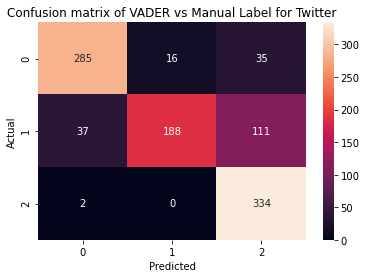

In [13]:
fig = plt.figure()
sns.heatmap(cm, annot = True, fmt='d')
plt.title("Confusion matrix of VADER vs Manual Label for Twitter")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
accuracy = accuracy_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred, average='macro')
precisionScore = precision_score(y_true, y_pred, average='macro')
recallScore = recall_score(y_true, y_pred, average='macro')

print("Accuracy: {}%\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(f'{accuracy*100:.2f}', f'{f1Score:.3f}', f'{precisionScore:.3f}', f'{recallScore:.3f}'))

Accuracy: 80.06%
F1-score: 0.793
Precision Score: 0.832
Recall Score: 0.801


# Naive Bayes Classifier

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df[['cleanText']], 
                                                    df['Sentiment (2pos/1neu/0neg)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

In [16]:
vectorizer = CountVectorizer(ngram_range=(1,2))
cv = vectorizer.fit_transform(x_train['cleanText'])

In [17]:
clf = MultinomialNB().fit(cv, y_train)

In [18]:
test_vector = vectorizer.transform(x_test['cleanText'])
result = clf.predict(test_vector)
cmNB = metrics.confusion_matrix(y_test, result)
cmNB

array([[46,  9, 15],
       [11, 43,  9],
       [ 5,  6, 58]])

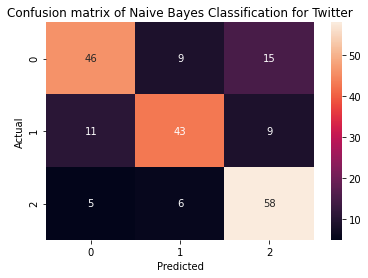

In [19]:
fig = plt.figure()
sns.heatmap(cmNB, annot = True, fmt='d')
plt.title("Confusion matrix of Naive Bayes Classification for Twitter")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# count vectorizing with unigram + bigram
accuracy = accuracy_score(y_test, result)
f1Score = f1_score(y_test, result, average='macro')
precisionScore= precision_score(y_test, result, average='macro')
recallScore = recall_score(y_test, result, average='macro')

print("Accuracy: {}%\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(f'{accuracy*100:.2f}', f'{f1Score:.3f}', f'{precisionScore:.3f}', f'{recallScore:.3f}'))

Accuracy: 72.77%
F1-score: 0.725
Precision Score: 0.730
Recall Score: 0.727


In [21]:
df.to_csv('twitter_dataset.csv')